# 🎯 Object Detection (YOLO & Faster R-CNN)

Welcome! In our last notebook, we covered image classification (labeling an *entire* image). Now, we're moving to a more complex and practical task: **Object Detection**.

Object detection doesn't just ask "What is in this image?" It asks "**What** is in this image, and **where** is it?"

**The Goal:** To produce a list of **bounding boxes** (coordinates) for every object in an image, along with a **class label** (e.g., "person," "car") and a **confidence score** for each.



Today, we'll explore the two dominant families of object detection models:

1.  **Two-Stage Detectors (e.g., Faster R-CNN):** These models first *propose* "regions of interest" (RoIs) and then *classify* and *refine* those regions. They are known for high accuracy.
2.  **One-Stage Detectors (e.g., YOLO):** These models treat detection as a single regression problem, predicting boxes and classes in *one pass*. They are known for incredible speed, making them perfect for real-time applications.

## 1. Setup: Installing Libraries

We'll use `torchvision` for Faster R-CNN and the official `ultralytics` library for YOLO. `pycocotools` is often needed for evaluation, and `matplotlib` / `PIL` are for visualization.

In [1]:
!pip install -q ultralytics pycocotools
!pip install -q "torchvision>=0.15"  # Ensure we have a recent torchvision for the best models

import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

from ultralytics import YOLO

from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2 # YOLO plotting uses OpenCV

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda
Torch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126


## 2. Part 1: Two-Stage Detection (Faster R-CNN)

**Faster R-CNN** (Region-based Convolutional Neural Network) is the canonical two-stage detector. It's the "R" in **Mask R-CNN**, which we'll see later.

### 💡 The Concept

It works in two steps:
1.  **Stage 1: Region Proposal Network (RPN):** A small network "scans" the image (using the features from a backbone like ResNet) and proposes a set of "regions of interest" (RoIs) where an object *might* be. It doesn't know *what* the object is, just that *something* is there.
2.  **Stage 2: Fast R-CNN Head:** For each proposed region, this "head" takes the features, classifies the object (e.g., "person," "car," "background"), and refines the bounding box to fit more tightly.



This separation makes it highly accurate but also slower than one-stage methods.

### Practical Example: Pre-trained Faster R-CNN

Let's use a pre-trained Faster R-CNN from `torchvision` to detect objects in a sample image.

In [2]:
# 1. Load a pre-trained Faster R-CNN model
# We use V2, which has improved accuracy and uses modern TorchVision APIs
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model_frcnn = fasterrcnn_resnet50_fpn_v2(weights=weights)
model_frcnn.eval()  # Set to evaluation mode
model_frcnn.to(device)

# Get the class names that this model was trained on (COCO dataset)
coco_names = weights.meta["categories"]
print(f"Model loaded. It can detect {len(coco_names)} classes.")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:00<00:00, 196MB/s]


Model loaded. It can detect 91 classes.


#### 2.1. Load and Preprocess Image

Object detection models are simpler to preprocess than classifiers. We just need to convert the image to a tensor. The model handles normalization internally.

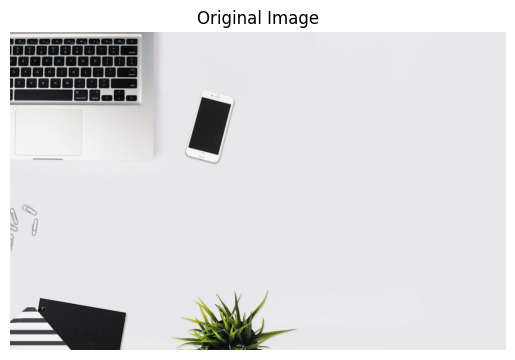

In [3]:
# 2. Load a sample image
img_url = "https://images.pexels.com/photos/1036808/pexels-photo-1036808.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

# 3. Define preprocessing transform
# Just convert to a tensor. The model expects [0, 255] uint8 or [0, 1] float.
preprocess = transforms.ToTensor()
img_tensor = preprocess(img)

# Add a batch dimension and send to device
input_batch = [img_tensor.to(device)] # Note: models expect a list of tensors for batching

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

#### 2.2. Run Inference and Visualize Results

The output of a `torchvision` detection model is a list of dictionaries, one for each image in the batch. Each dictionary contains:
* `'boxes'`: The `[xmin, ymin, xmax, ymax]` coordinates.
* `'labels'`: The integer ID for the class.
* `'scores'`: The confidence score (0.0 to 1.0).

Found 2 objects with >0.5 confidence.


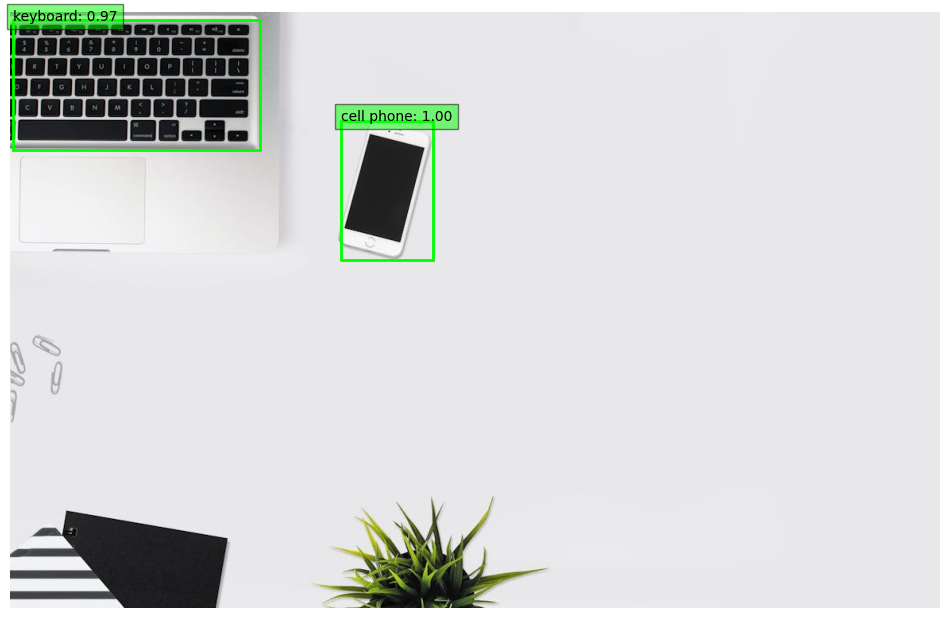

In [7]:
# 4. Run inference
with torch.no_grad():
    predictions = model_frcnn(input_batch)

# The output is a list, one element per image.
# Let's inspect the first (and only) prediction.
pred = predictions[0]

# 5. Filter predictions by a confidence threshold
confidence_threshold = 0.5
high_conf_indices = pred['scores'] > confidence_threshold

boxes = pred['boxes'][high_conf_indices].cpu()
labels = pred['labels'][high_conf_indices].cpu()
scores = pred['scores'][high_conf_indices].cpu()

print(f"Found {len(boxes)} objects with >{confidence_threshold} confidence.")

# 6. Visualization function
def draw_boxes(image, boxes, labels, scores, class_names):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        # Create a Rectangle patch
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        # Add label
        class_name = class_names[label.item()]
        ax.text(xmin, ymin, f'{class_name}: {score:.2f}',
                bbox=dict(facecolor='lime', alpha=0.5),
                fontsize=10, color='black')

    plt.axis('off')
    plt.show()

# 7. Display the results
# Convert original PIL image to numpy for plotting
draw_boxes(np.array(img), boxes, labels, scores, coco_names)

---

## 3. Part 2: One-Stage Detection (YOLO)

**YOLO (You Only Look Once)** completely changed the game. It frames object detection as a single-pass regression problem.

### 💡 The Concept

1.  **Grid System:** YOLO divides the image into a `S x S` grid.
2.  **Cell Responsibility:** Each grid cell is responsible for detecting objects whose *center* falls within that cell.
3.  **One Shot:** A single, massive CNN processes the entire image at once and, for each grid cell, predicts:
    * A set of bounding boxes (using "anchor boxes").
    * A confidence score for each box (does this box contain an object?).
    * A set of class probabilities for each box.



This unified architecture is *extremely* fast, making it the standard for real-time object detection on drones and cars. We'll use **YOLOv8**.

### Practical Example: YOLOv8 with `ultralytics`

The `ultralytics` library makes using YOLO incredibly simple.

In [8]:
# 1. Load a pre-trained YOLOv8 model
# 'yolov8n.pt' is the "nano" model, the smallest and fastest.
# The first time you run this, it will download the model.
model_yolo = YOLO('yolov8n.pt')
model_yolo.to(device)

print("YOLOv8 nano model loaded.")

YOLOv8 nano model loaded.


#### 3.1. Run Inference

The YOLO API is even simpler. We can just pass the URL or image path directly to the model.

In [10]:
# 2. Run inference on the same image
# The model handles all downloading and preprocessing.
results = model_yolo(img_url)

# The 'results' object is a list (one per image).
# Let's inspect the first result.
result = results[0]


Found https://images.pexels.com/photos/1036808/pexels-photo-1036808.jpeg locally at pexels-photo-1036808.jpeg
image 1/1 /content/pexels-photo-1036808.jpeg: 416x640 1 potted plant, 1 laptop, 1 cell phone, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


#### 3.2. Visualize Results

The `ultralytics` library has a built-in plotting function that makes visualization trivial.

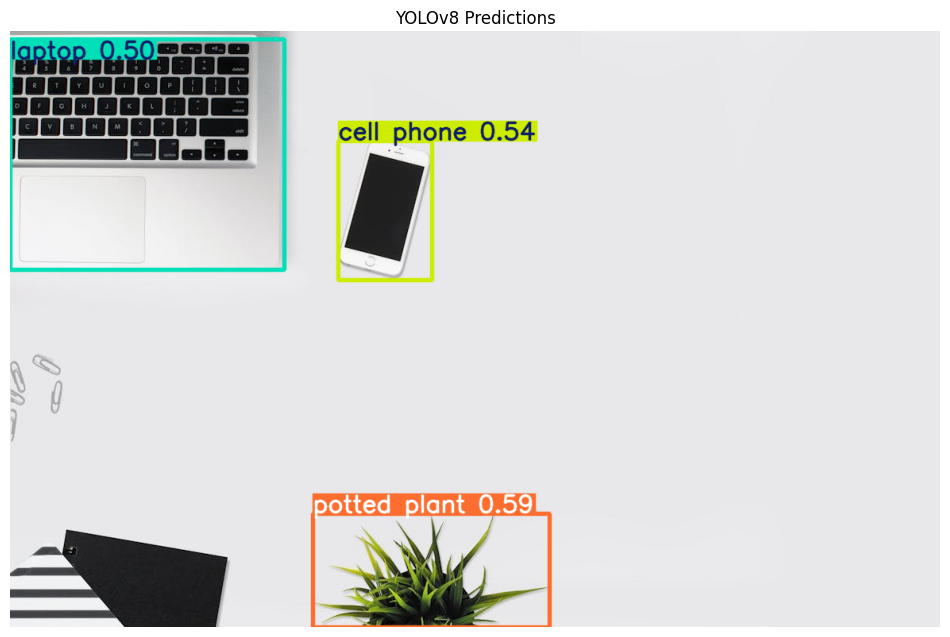

In [11]:
# 3. Use the built-in plot function
# This renders the image with boxes, labels, and scores.
# The result is a numpy array (in BGR format by default)
img_with_boxes_bgr = result.plot()

# Convert from BGR (used by OpenCV) to RGB (used by Matplotlib)
img_with_boxes_rgb = cv2.cvtColor(img_with_boxes_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 9))
plt.imshow(img_with_boxes_rgb)
plt.title("YOLOv8 Predictions")
plt.axis("off")
plt.show()

#### 3.3. Accessing the Raw Data (Optional)

Just to show that YOLO produces the same *kind* of data, here's how you can access the raw boxes and classes from the `results` object.

In [12]:
# 4. Accessing the raw prediction data
boxes_obj = result.boxes  # This is a 'Boxes' object

print("--- Raw YOLOv8 Output ---")
print("Boxes (xyxy):")
print(boxes_obj.xyxy[:3].cpu().numpy()) # Show first 3

print("\nConfidence Scores:")
print(boxes_obj.conf[:3].cpu().numpy()) # Show first 3

print("\nClass IDs:")
print(boxes_obj.cls[:3].cpu().numpy()) # Show first 3

# Get class names from the model's metadata
class_names = result.names
print(f"\nClass ID 0 maps to: {class_names[0]}")
print(f"Class ID 1 maps to: {class_names[1]}")

--- Raw YOLOv8 Output ---
Boxes (xyxy):
[[     381.96      607.46      679.48         750]
 [     413.55      138.23      531.08      313.15]
 [    0.36685       10.89      345.84      300.12]]

Confidence Scores:
[    0.59179     0.54073     0.50256]

Class IDs:
[         58          67          63]

Class ID 0 maps to: person
Class ID 1 maps to: bicycle


## 4. Comparison & Conclusion

We've seen two powerful approaches to the same problem.

| Feature | Faster R-CNN (Two-Stage) | YOLO (One-Stage) |
| :--- | :--- | :--- |
| **Philosophy** | "Propose, then Classify" | "Predict all at once" |
| **Speed** | 🐢 Slower (but still fast on GPU) | 🚀 Extremely Fast (Real-time) |
| **Accuracy** | ⭐⭐⭐⭐⭐ (Excellent, esp. small objects) | ⭐⭐⭐⭐ (Very good, was worse but has caught up) |
| **Complexity** | High (Two networks, RoI pooling) | Low (Single, unified network) |
| **Best For** | Accuracy is paramount, offline processing | Real-time apps, speed is critical |

**Key Takeaways:**
* **Object Detection** = Classification + Localization.
* **Two-Stage (Faster R-CNN)** models are accurate and robust, making them a great foundation for more complex tasks.
* **One-Stage (YOLO)** models are built for speed and are the industry standard for real-time detection.

**Next Steps:**
We've learned to draw a *box* around an object. But what if we want to know the *exact pixels* that object occupies? This is **Segmentation**.

We'll start with **Semantic Segmentation** (labeling every pixel in an image, e.g., "all pixels belonging to 'car'"), which is our next notebook.